# **Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from nltk.corpus import stopwords
import string
import re
import warnings
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
import html
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Load Dataset
train_df = pd.read_csv("/content/drive/MyDrive/IMDBData/IMDB Dataset.csv")
train_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# **Data Understanding & EDA**

Total number:                        50000
Total number of Bad reviews:         25000
Total number of good reviews:        25000



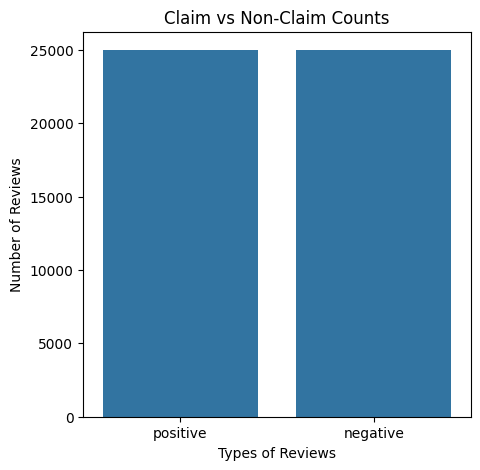

In [ ]:
good_reviews = train_df[train_df['sentiment']=='positive']['review']
bad_reviews = train_df[train_df['sentiment']=='negative']['review']

# Bar plot
plt.figure(figsize=(5,5))
ax = sns.countplot(data=train_df, x='sentiment')

print('==========================================')
print('Total number: ' + ' ' * 23 + str(good_reviews.count() + bad_reviews.count()))
print('Total number of Bad reviews: ' +  ' ' * 8 + str(good_reviews.count()))
print('Total number of good reviews: ' + ' ' * 7 + str(bad_reviews.count()))
print('==========================================\n')

plt.title('Claim vs Non-Claim Counts')
plt.xlabel('Types of Reviews')
plt.ylabel('Number of Reviews')
plt.show()

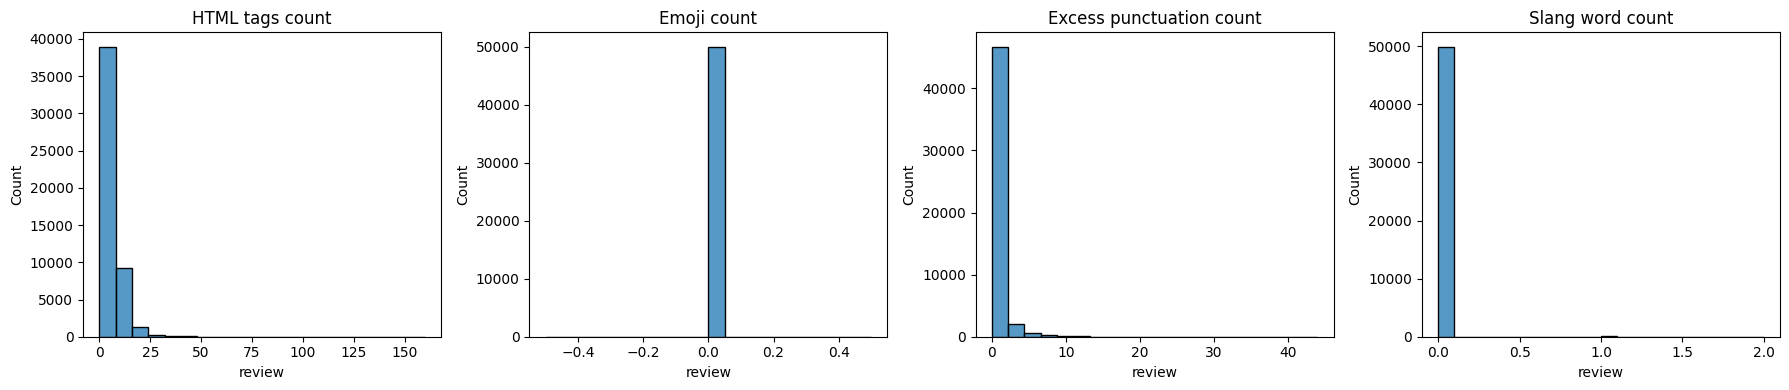

In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning)

#Spoting weird patterns: excessive punctuation, emojis, HTML, slang

# Emoji pattern
emoji_pattern = re.compile("[\U00010000-\U0010ffff]", flags=re.UNICODE)
slang_words = {"lol", "omg", "wtf", "brb", "lmao", "idk"}

fig, axes = plt.subplots(1, 4, figsize=(18, 4))

# HTML tags count
sns.histplot(
    train_df['review'].str.count(r"<[^>]+>"),
    bins=20, ax=axes[0]
).set_title("HTML tags count")

# Emoji count
sns.histplot(
    train_df['review'].apply(lambda x: len(emoji_pattern.findall(str(x)))),
    bins=20, ax=axes[1]
).set_title("Emoji count")

# Excess punctuation count (!!?? ...)
sns.histplot(
    train_df['review'].str.count(r"(\!{2,}|\?{2,}|\.{3,})"),
    bins=20, ax=axes[2]
).set_title("Excess punctuation count")

# Slang count
sns.histplot(
    train_df['review'].apply(lambda x: sum(1 for w in str(x).lower().split() if w in slang_words)),
    bins=20, ax=axes[3]
).set_title("Slang word count")

plt.tight_layout()
plt.show()

In [ ]:
# Missing value counts (robust plotting)
missing_counts = train_df.isna().sum().sort_values(ascending=False)
print(missing_counts.to_frame("NaN_count"))

if (missing_counts > 0).any():
    to_plot = missing_counts[missing_counts > 0]
    plt.figure(figsize=(6,3))
    to_plot.plot(kind='bar', color='salmon')
    plt.title("Missing Values per Column")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("===============================")
    print("No missing values found — nice!")

           NaN_count
review             0
sentiment          0
No missing values found — nice!


In [ ]:
!pip install nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

/tmp/ipython-input-3590201244.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(count_zeros,ax=ax1,color='Blue')
/tmp/ipython-input-3590201244.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(count_ones,ax=ax2,color='Orange')


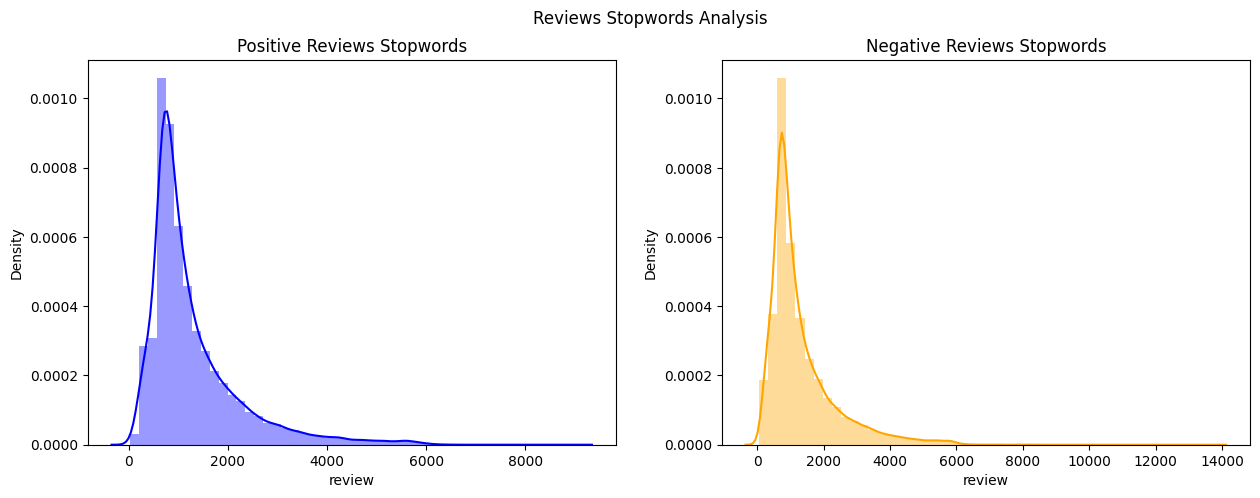

In [ ]:
#Analyse Stopwords

count_good=train_df[train_df['sentiment']=='positive']
count_bad=train_df[train_df['sentiment']=='negative']

def plot_count_1(count_ones,count_zeros,title_1,title_2,subtitle):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    sns.distplot(count_zeros,ax=ax1,color='Blue')
    ax1.set_title(title_1)
    sns.distplot(count_ones,ax=ax2,color='Orange')
    ax2.set_title(title_2)
    fig.suptitle(subtitle)
    plt.show()


stops=set(stopwords.words('english'))
count_good_stops=count_good['review'].apply(lambda z : np.mean([len(z) for w in str(z).split()]))
count_bad_stops=count_bad['review'].apply(lambda z : np.mean([len(z) for w in str(z).split()]))
plot_count_1(count_good_stops,count_bad_stops,"Positive Reviews Stopwords","Negative Reviews Stopwords","Reviews Stopwords Analysis")

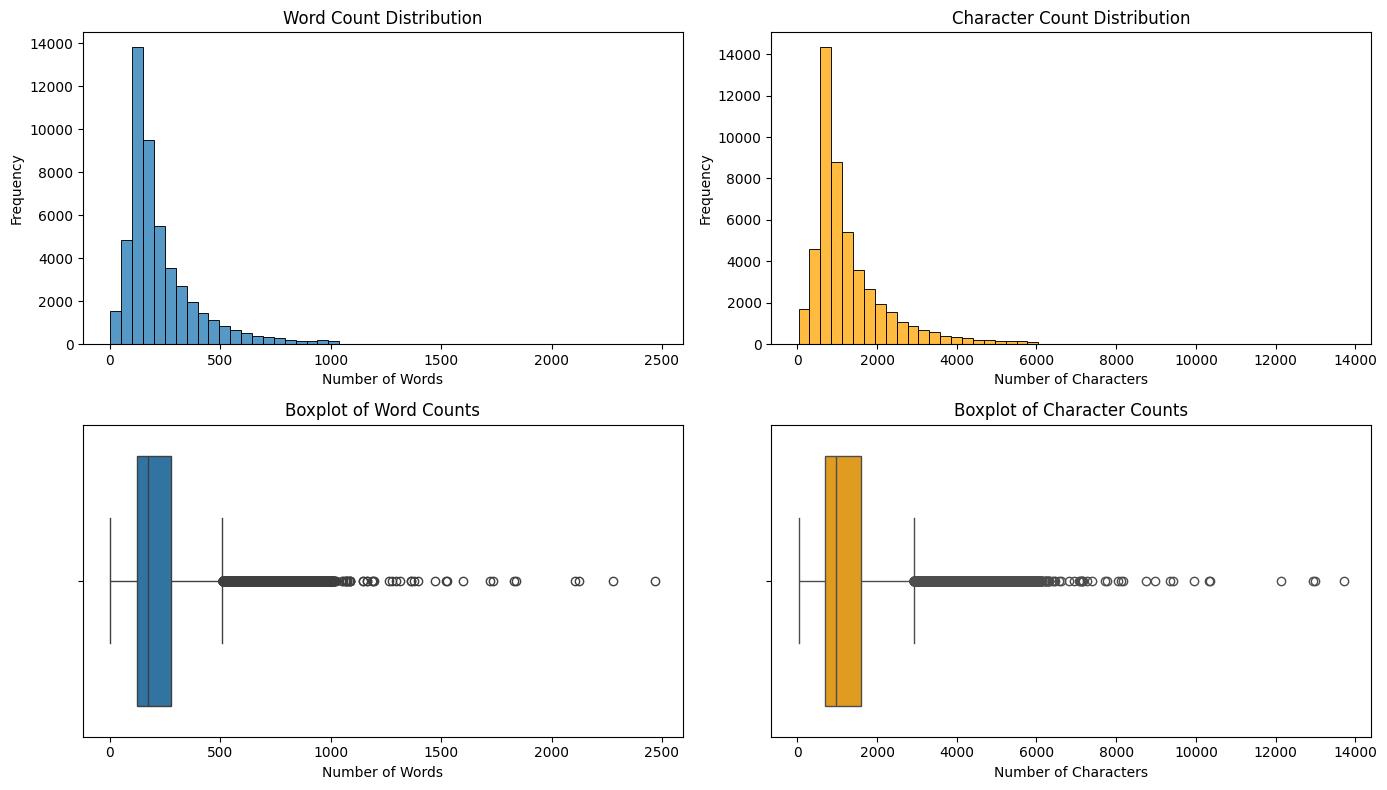

In [ ]:
# Ensure lengths are calculated
train_df['word_count'] = train_df['review'].astype(str).str.split().apply(len)
train_df['char_count'] = train_df['review'].astype(str).str.len()

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Histogram - Word length
sns.histplot(train_df['word_count'], bins=50, ax=axes[0,0], kde=False)
axes[0,0].set_title("Word Count Distribution")
axes[0,0].set_xlabel("Number of Words")
axes[0,0].set_ylabel("Frequency")

# Histogram - Char length
sns.histplot(train_df['char_count'], bins=50, ax=axes[0,1], kde=False, color='orange')
axes[0,1].set_title("Character Count Distribution")
axes[0,1].set_xlabel("Number of Characters")
axes[0,1].set_ylabel("Frequency")

# Boxplot - Word length
sns.boxplot(x=train_df['word_count'], ax=axes[1,0])
axes[1,0].set_title("Boxplot of Word Counts")
axes[1,0].set_xlabel("Number of Words")

# Boxplot - Char length
sns.boxplot(x=train_df['char_count'], ax=axes[1,1], color='orange')
axes[1,1].set_title("Boxplot of Character Counts")
axes[1,1].set_xlabel("Number of Characters")

plt.tight_layout()
plt.show()

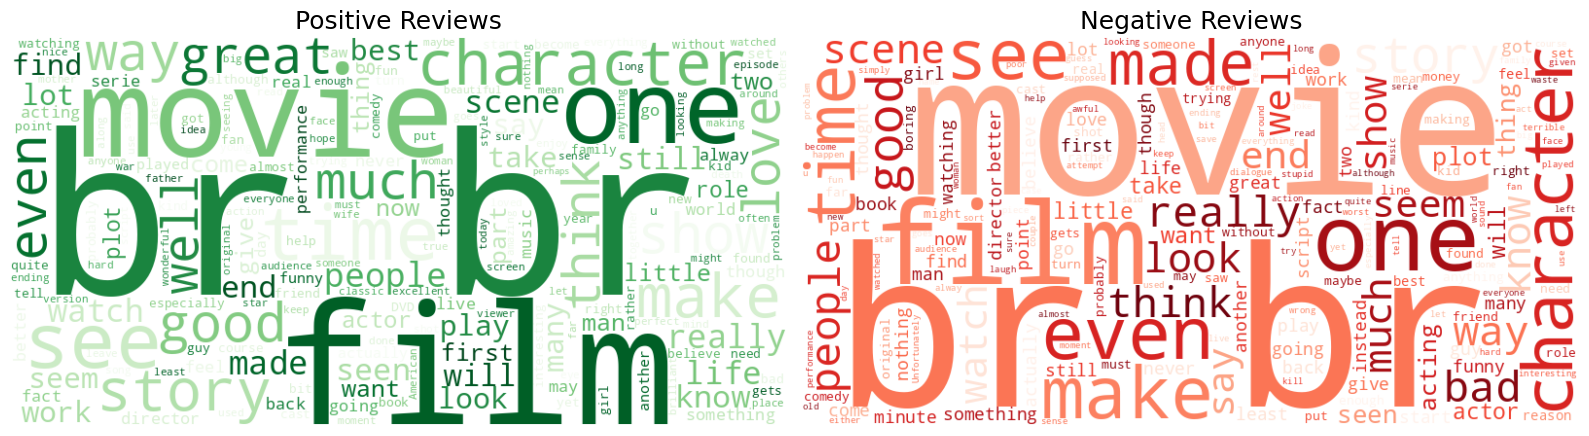

In [ ]:
pos_text = " ".join(train_df.loc[train_df['sentiment'] == 'positive', 'review'].astype(str))
neg_text = " ".join(train_df.loc[train_df['sentiment'] == 'negative', 'review'].astype(str))

# Generate word clouds
pos_wc = WordCloud(width=800, height=400, background_color='white',
                   max_words=200, colormap='Greens').generate(pos_text)

neg_wc = WordCloud(width=800, height=400, background_color='white',
                   max_words=200, colormap='Reds').generate(neg_text)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(pos_wc, interpolation='bilinear')
axes[0].set_title("Positive Reviews", fontsize=18)
axes[0].axis("off")

axes[1].imshow(neg_wc, interpolation='bilinear')
axes[1].set_title("Negative Reviews", fontsize=18)
axes[1].axis("off")

plt.tight_layout()
plt.show()

<Axes: >

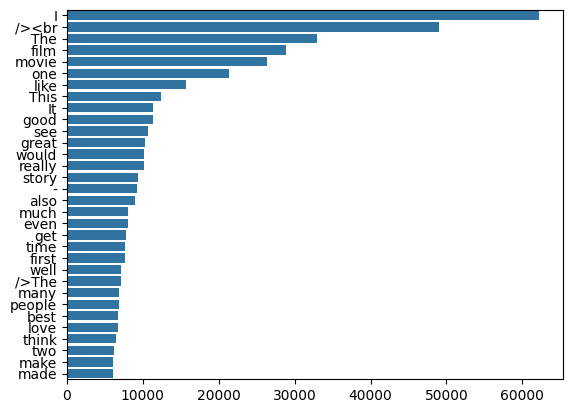

In [ ]:
#stops = set(stopwords.words('english'))

#Simplified counter function
def create_corpus(word):
    corpus=[]

    for x in train_df[train_df['sentiment']==word]['review'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

corpus=create_corpus('positive')
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:100]:
    if (word not in stops) :
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)

# **Text Cleaning & Preprocessing**

In [ ]:
URL_RE   = re.compile(r"https?://\S+|www\.\S+", flags=re.I)
HTML_RE  = re.compile(r"<[^>]+>")
EMOJI_RE = re.compile("["
                      u"\U0001F600-\U0001F64F"
                      u"\U0001F300-\U0001F5FF"
                      u"\U0001F680-\U0001F6FF"
                      u"\U0001F1E0-\U0001F1FF"
                      u"\u2600-\u26FF"
                      u"\u2700-\u27BF"
                      "]+", flags=re.UNICODE)

# remove punctuation but KEEP ! ? . ,
PUNCT_RE = re.compile(r"[^\w\s'!?.,]", flags=re.UNICODE)
SPACE_RE = re.compile(r"\s+")

CONTRACTIONS = {
    "ain't":"is not", "aren't":"are not", "can't":"can not", "can't've":"can not have",
    "’cause":"because","cause":"because","could've":"could have","couldn't":"could not",
    "couldn't've":"could not have","didn't":"did not","doesn't":"does not","don't":"do not",
    "hadn't":"had not","hadn't've":"had not have","hasn't":"has not","haven't":"have not",
    "he'd":"he would","he'd've":"he would have","he'll":"he will","he's":"he is",
    "how'd":"how did","how'd'y":"how do you","how'll":"how will","how's":"how is",
    "i'd":"i would","i'd've":"i would have","i'll":"i will","i'm":"i am","i've":"i have",
    "isn't":"is not","it'd":"it would","it'd've":"it would have","it'll":"it will","it's":"it is",
    "let's":"let us","ma'am":"madam","mayn't":"may not","might've":"might have",
    "mightn't":"might not","mightn't've":"might not have","must've":"must have",
    "mustn't":"must not","mustn't've":"must not have","needn't":"need not",
    "o'clock":"of the clock","oughtn't":"ought not","shan't":"shall not","sha'n't":"shall not",
    "she'd":"she would","she'd've":"she would have","she'll":"she will","she's":"she is",
    "should've":"should have","shouldn't":"should not","shouldn't've":"should not have",
    "so've":"so have","that'd":"that would","that'd've":"that would have","that's":"that is",
    "there'd":"there would","there'd've":"there would have","there's":"there is",
    "they'd":"they would","they'd've":"they would have","they'll":"they will",
    "they're":"they are","they've":"they have","wasn't":"was not","we'd":"we would",
    "we'd've":"we would have","we'll":"we will","we're":"we are","we've":"we have",
    "weren't":"were not","what'll":"what will","what're":"what are","what's":"what is",
    "what've":"what have","where'd":"where did","where's":"where is","who'll":"who will",
    "who's":"who is","why'd":"why did","why's":"why is","won't":"will not","would've":"would have",
    "wouldn't":"would not","wouldn't've":"would not have","y'all":"you all","ya'll":"you all",
    "you'd":"you would","you'd've":"you would have","you'll":"you will","you're":"you are",
    "you've":"you have"
}

# build regex once (handles word boundaries)
CONTR_PAT = re.compile(
    r"\b(" + "|".join(re.escape(k) for k in sorted(CONTRACTIONS.keys(), key=len, reverse=True)) + r")\b",
    flags=re.IGNORECASE
)

def expand_contractions(text: str) -> str:
    def _repl(m):
        key = m.group(0).lower()
        return CONTRACTIONS.get(key, key)
    return CONTR_PAT.sub(_repl, text)

def clean_review(text: str) -> str:
    s = "" if text is None else str(text)

    # remove html & urls early
    s = URL_RE.sub(" ", s)
    s = HTML_RE.sub(" ", s)

    # unescape entities like &amp; &nbsp;
    s = html.unescape(s)

    # LOWER before expanding? No—expand is case-insensitive, but we’ll lower after
    s = expand_contractions(s)

    # drop emojis/symbols (It is not relevant for our dataset but it is done for good practice)
    s = EMOJI_RE.sub(" ", s)

    # keep only word chars/space and ! ? . ,
    s = PUNCT_RE.sub(" ", s)

    # normalize whitespace & lowercase
    s = SPACE_RE.sub(" ", s).strip().lower()
    return s

train_df["clean"] = train_df["review"].apply(clean_review)

In [ ]:
#quick checking for cleaned dataset
train_df[["review","clean"]].head(5)

,review,clean
0,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,a wonderful little production. the filming tec...
2,I thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,basically there is a family where a little boy...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei's love in the time of money is a...


In [ ]:
#Cleaning stopwords
stop_words = stopwords.words('english')

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

train_df['clean'] = train_df['clean'].apply(remove_stopwords)

In [ ]:
import nltk

def ensure_nltk(resource, pkg=None):
    try:
        nltk.data.find(resource)
    except LookupError:
        nltk.download(pkg or resource.split('/')[-1])

ensure_nltk('corpora/wordnet', 'wordnet')
ensure_nltk('corpora/omw-1.4', 'omw-1.4')
ensure_nltk('tokenizers/punkt', 'punkt')
ensure_nltk('tokenizers/punkt_tab', 'punkt_tab')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
#Lemmatize the dataset
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

def lemma_traincorpus(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)  # split into words
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

train_df['clean'] = train_df['clean'].apply(lambda z: lemma_traincorpus(z))

In [ ]:
#quick checking for lemmatized and cleaned from stopwords dataset
train_df["clean"].head(5)

,clean
0,one reviewer mentioned watching 1 oz episode h...
1,wonderful little production . filming techniqu...
2,thought wonderful way spend time hot summer we...
3,basically family little boy jake think zombie ...
4,petter mattei 's love time money visually stun...


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_df['sentiment'])

train_df['sentiment_encoded'] = le.transform(train_df['sentiment'])

In [ ]:
train_df.head()

,review,sentiment,word_count,char_count,clean,sentiment_encoded
0,One of the other reviewers has mentioned that ...,positive,307,1761,one reviewer mentioned watching 1 oz episode h...,1
1,A wonderful little production. <br /><br />The...,positive,162,998,wonderful little production . filming techniqu...,1
2,I thought this was a wonderful way to spend ti...,positive,166,926,thought wonderful way spend time hot summer we...,1
3,Basically there's a family where a little boy ...,negative,138,748,basically family little boy jake think zombie ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230,1317,petter mattei 's love time money visually stun...,1


# **Vectorization**

In [ ]:
X = train_df['clean']
y = train_df['sentiment_encoded']

print(len(X), len(y))

50000 50000


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

37500 37500
12500 12500


In [ ]:
# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(X_train)

CountVectorizer()

In [ ]:
# Use the trained to create a document-term matrix from train and test sets
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

In [ ]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=20000)

### **TF-IDF**

In [ ]:
tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(X_train_dtm)
X_train_tfidf = tfidf_transformer.transform(X_train_dtm)

X_train_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3692677 stored elements and shape (37500, 82440)>

### **Word Embeddings: GloVe**

In [ ]:
texts = train_df['clean']
target = train_df['sentiment_encoded']

In [ ]:
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

97708

In [ ]:
def embed(corpus):
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(texts),
    length_long_sentence,
    padding='post'
)

train_padded_sentences

array([[    4,  1095,   978, ...,     0,     0,     0],
       [  304,    49,   239, ...,     0,     0,     0],
       [   91,   304,    28, ...,     0,     0,     0],
       ...,
       [ 3000,  4108, 34506, ...,     0,     0,     0],
       [   80,  2866,   827, ...,     0,     0,     0],
       [    4,  5500,    99, ...,     0,     0,     0]], dtype=int32)

In [ ]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('/content/drive/MyDrive/GloVe/glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

# embeddings_dictionary

In [ ]:
# Now we will load embedding vectors of those words that appear in the
# Glove dictionary. Others will be initialized to 0.

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.38251001,  0.14821   ,  0.60601002, ...,  0.058921  ,
         0.091112  ,  0.47283   ],
       [ 0.19915999, -0.049702  ,  0.24579   , ..., -0.068109  ,
         0.017651  ,  0.06455   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.15927   , -0.37156999, -0.24017   , ..., -0.20835   ,
        -0.28694001,  0.27697   ],
       [ 0.027842  ,  0.59833002,  0.53632998, ...,  0.12272   ,
         0.48018   ,  0.54391003]])

# NaiVe Bayes DTM

In [ ]:
nb = MultinomialNB()

# Train the model
nb.fit(X_train_dtm, y_train)

# Make class anf probability predictions
y_pred_class = nb.predict(X_test_dtm)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      6157
           1       0.88      0.84      0.86      6343

    accuracy                           0.86     12500
   macro avg       0.86      0.86      0.86     12500
weighted avg       0.86      0.86      0.86     12500



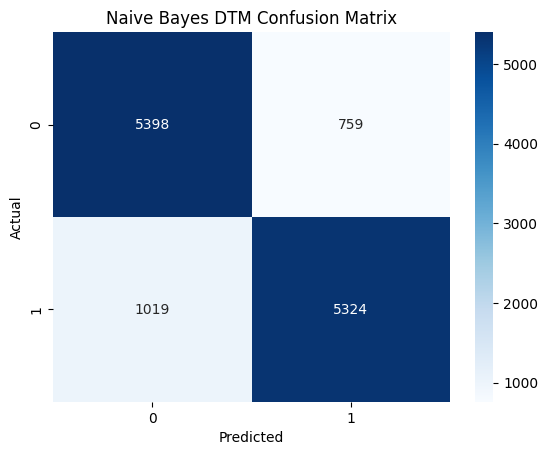

In [ ]:
#print(f1_score(y_test, y_pred_class, average="macro", zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_class)
print(classification_report(y_test, y_pred_class))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Naive Bayes DTM Confusion Matrix")
plt.show()

# **LSTM**

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences,
    target,
    test_size=0.25
)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))
print(len(X_val), len(y_val))

37500 37500
6250 6250
6250 6250


In [ ]:
def glove_lstm():
    model = Sequential()

    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights = [embedding_matrix],
        trainable=False
    ))

    model.add(Bidirectional(LSTM(
        units = 128,
        return_sequences = True,
    )))

    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = glove_lstm()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     9,770,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,770,800 (37.27 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,770,800 (37.27 MB)

In [ ]:
# Load the model and train!!

model = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.h5',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    verbose = 1,
    patience = 5,
    min_lr = 0.001
)

history = model.fit(
    X_train,
    y_train,
    epochs = 7,
    batch_size = 16,
    validation_data = (X_val, y_val),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7429 - loss: 0.5905
Epoch 1: val_loss improved from inf to 0.37514, saving model to model.h5


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 248s 103ms/step - accuracy: 0.7429 - loss: 0.5904 - val_accuracy: 0.8440 - val_loss: 0.3751 - learning_rate: 0.0010
Epoch 2/7
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8128 - loss: 0.4450
Epoch 2: val_loss did not improve from 0.37514
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 241s 103ms/step - accuracy: 0.8128 - loss: 0.4450 - val_accuracy: 0.5486 - val_loss: 0.9653 - learning_rate: 0.0010
Epoch 3/7
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8234 - loss: 0.4257
Epoch 3: val_loss did not improve from 0.37514
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 241s 103ms/step - accuracy: 0.8234 - loss: 0.4257 - val_accuracy: 0.8157 - val_loss: 0.4217 - learning_rate: 0.0010
Epoch 4/7
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8327 - loss: 0.4031
Epoch 4: val_loss did not improve from 0.37514
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 242s 103ms/step - accuracy: 0.8327 - loss: 0.4031 - val_accuracy: 0.8016 - val_loss: 0.4473 - learning_rate: 0.0010
Epoch 5

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 241s 103ms/step - accuracy: 0.8477 - loss: 0.3833 - val_accuracy: 0.8666 - val_loss: 0.3162 - learning_rate: 0.0010
Epoch 7/7
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8445 - loss: 0.3922
Epoch 7: val_loss did not improve from 0.31616
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 242s 103ms/step - accuracy: 0.8445 - loss: 0.3922 - val_accuracy: 0.8485 - val_loss: 0.3787 - learning_rate: 0.0010


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      3051
           1       0.91      0.82      0.86      3199

    accuracy                           0.87      6250
   macro avg       0.87      0.87      0.87      6250
weighted avg       0.87      0.87      0.87      6250



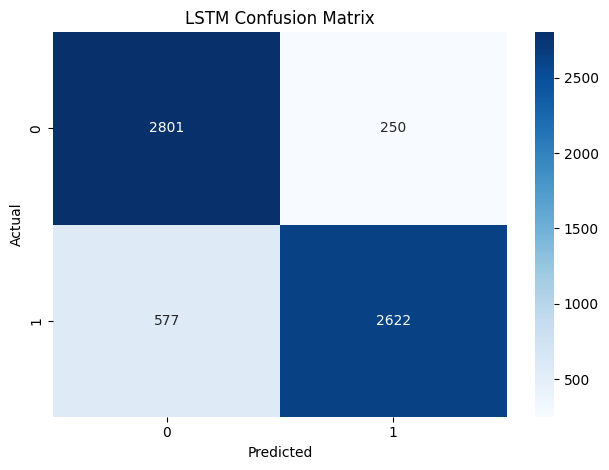

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

# Load the best model saved by ModelCheckpoint (best val_loss)
model = load_model("model.h5")

# Predict → flatten to 1D
probs = model.predict(X_test, batch_size=256).ravel()
y_preds = (probs >= 0.5).astype("int32")

# Ensure y_test is 1D too
y_true = np.asarray(y_test).ravel()

# Confusion Matrix + Report
cm = confusion_matrix(y_true, y_preds, labels=[0, 1])
print(classification_report(y_true, y_preds, digits=2))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("LSTM Confusion Matrix")
plt.tight_layout()
plt.show()


# **BERT**

I decided to use ALBERT and distilBERT instead of BERT-based for speed and accuracy balance. You can look at that artictle: https://arxiv.org/pdf/1909.11942

In [4]:
!pip install transformers datasets accelerate torch evaluate
!pip uninstall -y dopamine-rl tensorflow-decision-forests bigframes gcsfs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.2 MB/s eta 0:00:00
Found existing installation: dopamine_rl 4.1.2
Uninstalling dopamine_rl-4.1.2:
  Successfully uninstalled dopamine_rl-4.1.2
Found existing installation: tensorflow_decision_forests 1.12.0
Uninstalling tensorflow_decision_forests-1.12.0:
  Successfully uninstalled tensorflow_decision_forests-1.12.0
Found existing installation: bigframes 2.17.0
Uninstalling bigframes-2.17.0:
  Successfully uninstalled bigframes-2.17.0
Found existing installation: gcsfs 2025.3.0
Uninstalling gcsfs-2025.3.0:
  Successfully uninstalled gcsfs-2025.3.0


In [5]:
import torch
from transformers import (
    AlbertTokenizer, AlbertForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding
)
from datasets import Dataset, DatasetDict
from transformers import logging
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import re, html
from sklearn.preprocessing import LabelEncoder
from transformers import EarlyStoppingCallback
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [6]:
train_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
URL_RE   = re.compile(r"https?://\S+|www\.\S+", flags=re.I)
HTML_RE  = re.compile(r"<[^>]+>")
SPACE_RE = re.compile(r"\s+")

# If you really want to map emojis, use a library; otherwise just keep them.
# Here we keep all characters; no emoji stripping.

def clean_for_transformer(text: str, lowercase: bool = True) -> str:
    s = "" if text is None else str(text)
    s = URL_RE.sub(" <URL> ", s)
    s = HTML_RE.sub(" ", s)
    s = html.unescape(s)

    # (optional) normalize weird quotes/dashes
    s = s.replace("’", "'").replace("“", '"').replace("”", '"').replace("–", "-").replace("—", "-")

    s = SPACE_RE.sub(" ", s).strip()
    if lowercase:
        s = s.lower()
    return s

# usage:
# lowercase=True for ALBERT (uncased); False for DeBERTa/Roberta (cased)
is_uncased = True  # set False if you switch to DeBERTa/Roberta
train_df["clean"] = train_df["review"].apply(lambda t: clean_for_transformer(t, lowercase=is_uncased))

In [8]:
train_df["clean"].head()

,clean
0,one of the other reviewers has mentioned that ...
1,a wonderful little production. the filming tec...
2,i thought this was a wonderful way to spend ti...
3,basically there's a family where a little boy ...
4,"petter mattei's ""love in the time of money"" is..."


In [9]:
le = LabelEncoder()
le.fit(train_df['sentiment'])

train_df['sentiment_encoded'] = le.transform(train_df['sentiment'])

In [10]:
X = train_df['clean']
y = train_df['sentiment_encoded']

print(len(X), len(y))
X.head()

50000 50000


,clean
0,one of the other reviewers has mentioned that ...
1,a wonderful little production. the filming tec...
2,i thought this was a wonderful way to spend ti...
3,basically there's a family where a little boy ...
4,"petter mattei's ""love in the time of money"" is..."


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))
print(len(X_val), len(y_val))

37500 37500
6250 6250
6250 6250


In [12]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    accuracy = accuracy_score(labels, predictions)

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# **ALBERT Based**

In [13]:
logging.set_verbosity_error()
# Choose ALBERT model variant
model_name = "albert-base-v2"

# Initialize tokenizer and model
tokenizer = AlbertTokenizer.from_pretrained(model_name)
model = AlbertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(set(y_train))
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

In [14]:
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        padding=True,
        max_length=512,  # Adjust based on your text length
        return_tensors="pt"
    )

train_dataset = Dataset.from_dict({
    'text': X_train,
    'labels': y_train
})

test_dataset = Dataset.from_dict({
    'text': X_test,
    'labels': y_test
})

val_dataset = Dataset.from_dict({
    'text': X_val,
    'labels': y_val
})

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/37500 [00:00<?, ? examples/s]

Map:   0%|          | 0/6250 [00:00<?, ? examples/s]

Map:   0%|          | 0/6250 [00:00<?, ? examples/s]

In [15]:
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"

training_args = TrainingArguments(
    output_dir='/kaggle/working/albert-finetuned',
    num_train_epochs=10,              # Adjust based on your dataset size
    learning_rate=2e-5,
    per_device_train_batch_size=24,   # Reduce if you get OOM errors
    per_device_eval_batch_size=48,
    warmup_steps=500,
    weight_decay=0.01,
    disable_tqdm=False,
    logging_dir='/kaggle/working/logs',
    logging_steps=50,
    logging_first_step=True,
    eval_strategy="epoch",           # Changed from 'evaluation_strategy'
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,
    report_to=[],  # Disable wandb logging in Kaggle
    dataloader_pin_memory=False,# Can help with memory issues
    overwrite_output_dir=True,
    save_total_limit=2
)

In [16]:
# Data collator for padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Start training
print("Starting training...")
trainer.train()

# Save the final model
trainer.save_model('/kaggle/working/albert-final-model')
tokenizer.save_pretrained('/kaggle/working/albert-final-model')

/tmp/ipython-input-1954110354.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.268000,0.170239,0.936320,0.936312,0.936331,0.936320
2,0.165000,0.230381,0.926400,0.926117,0.930226,0.926400
3,0.124500,0.228647,0.939200,0.939176,0.939326,0.939200
4,0.082300,0.286353,0.935680,0.935695,0.936289,0.935680
5,0.058200,0.345103,0.938080,0.937990,0.939152,0.938080


('/kaggle/working/albert-final-model/tokenizer_config.json',
 '/kaggle/working/albert-final-model/special_tokens_map.json',
 '/kaggle/working/albert-final-model/spiece.model',
 '/kaggle/working/albert-final-model/added_tokens.json')

ALBERT Test Results:
eval_loss: 0.2166
eval_accuracy: 0.9416
eval_f1: 0.9416
eval_precision: 0.9417
eval_recall: 0.9416
eval_runtime: 45.9014
eval_samples_per_second: 136.1610
eval_steps_per_second: 2.8540
epoch: 5.0000

 ALBERT Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      3128
           1       0.93      0.95      0.94      3122

    accuracy                           0.94      6250
   macro avg       0.94      0.94      0.94      6250
weighted avg       0.94      0.94      0.94      6250



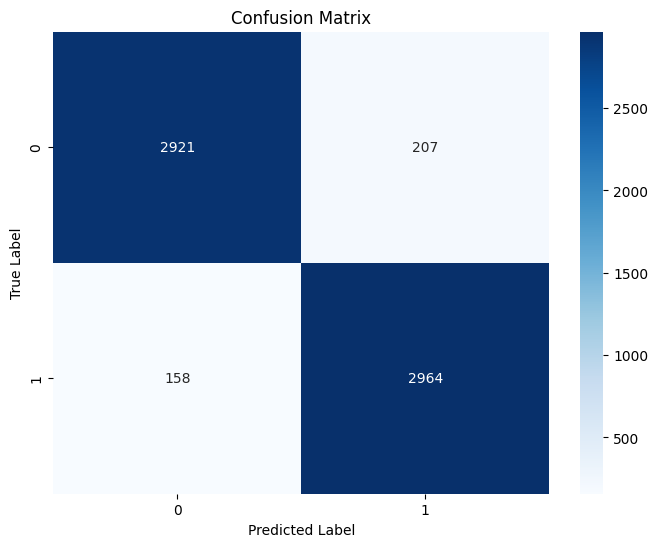

In [17]:
# Evaluate on test set
test_results = trainer.evaluate(test_dataset)
print("ALBERT Test Results:")
for key, value in test_results.items():
    print(f"{key}: {value:.4f}")

# Get predictions for detailed analysis
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Print classification report
print("\n ALBERT Classification Report:")
print(classification_report(y_test, predicted_labels))

# Create confusion matrix (if needed)
cm = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# **DistilBERT**

In [23]:
from transformers import (
    DistilBertTokenizer, DistilBertForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding
)

In [24]:
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2  # Adjust based on your number of classes
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [25]:
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        padding=True,
        max_length=512,  # Adjust based on your text length
        return_tensors="pt"
    )

train_dataset = Dataset.from_dict({
    'text': X_train,
    'labels': y_train
})

test_dataset = Dataset.from_dict({
    'text': X_test,
    'labels': y_test
})

val_dataset = Dataset.from_dict({
    'text': X_val,
    'labels': y_val
})

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/37500 [00:00<?, ? examples/s]

Map:   0%|          | 0/6250 [00:00<?, ? examples/s]

Map:   0%|          | 0/6250 [00:00<?, ? examples/s]

In [26]:
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"

training_args = TrainingArguments(
    output_dir='/kaggle/working/distilbert-finetuned',
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=2,
    learning_rate=2e-5,
    warmup_ratio=0.06,
    weight_decay=0.01,
    disable_tqdm=False,
    logging_dir='/kaggle/working/logs',
    logging_steps=50,
    logging_first_step=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    report_to=[],  # Disable wandb logging in Kaggle
    dataloader_pin_memory=False,# Can help with memory issues
    overwrite_output_dir=True,
    save_total_limit=2
)

In [27]:
# Data collator for padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Start training
print("Starting training...")
trainer.train()

# Save the final model
trainer.save_model('/kaggle/working/distilbert-final-model')
tokenizer.save_pretrained('/kaggle/working/distilbert-final-model')

/tmp/ipython-input-3840363800.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.221400,0.200962,0.922880,0.922898,0.923529,0.922880
2,0.152900,0.204154,0.925440,0.925261,0.927483,0.925440
3,0.097300,0.207553,0.931520,0.931536,0.932010,0.931520
4,0.058600,0.251635,0.932000,0.931880,0.933370,0.932000
5,0.056900,0.305436,0.927360,0.927373,0.928371,0.927360
6,0.024200,0.322105,0.936480,0.936483,0.936489,0.936480
7,0.029100,0.317725,0.936320,0.936297,0.936425,0.936320
8,0.014900,0.332468,0.934880,0.934873,0.934884,0.934880


('/kaggle/working/distilbert-final-model/tokenizer_config.json',
 '/kaggle/working/distilbert-final-model/special_tokens_map.json',
 '/kaggle/working/distilbert-final-model/vocab.txt',
 '/kaggle/working/distilbert-final-model/added_tokens.json')

Test Results:
eval_loss: 0.2981
eval_accuracy: 0.9395
eval_f1: 0.9395
eval_precision: 0.9395
eval_recall: 0.9395
eval_runtime: 6.7540
eval_samples_per_second: 925.3760
eval_steps_per_second: 14.5100
epoch: 8.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3128
           1       0.94      0.94      0.94      3122

    accuracy                           0.94      6250
   macro avg       0.94      0.94      0.94      6250
weighted avg       0.94      0.94      0.94      6250



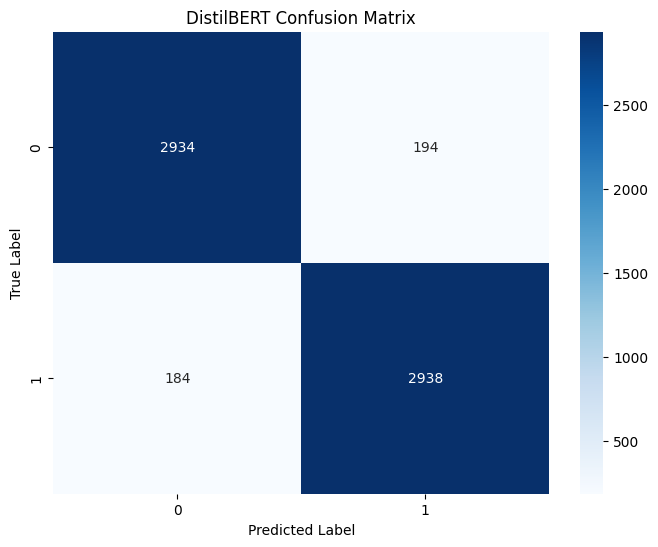

In [28]:
# Evaluate on test set
test_results = trainer.evaluate(test_dataset)
print("Test Results:")
for key, value in test_results.items():
    print(f"{key}: {value:.4f}")

# Get predictions for detailed analysis
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, predicted_labels))

# Create confusion matrix (if needed)
cm = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('DistilBERT Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()